# 2. Small-scale ChatGPT - generování textu pomocí neuronových sítí

!pip install -r requirements.txt

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [47]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [48]:
#device = 'cpu'  # Force CPU for this example

In [49]:
torch.device(device)

device(type='cuda')

# Generování jmen pomocí jednoduché RNN

## Příprava dat

Databáze evropských jmen a příjmení: https://data.europa.eu/data/datasets/5bc35259634f41122d982759?locale=cs

Složka /datasets/SeznamJmenCR

In [50]:
import glob
import pandas as pd

In [51]:
dfs = pd.read_csv('datasets/SeznamJmenCR/OpenData_-_Seznam_jmen_k_2025-05-31.csv', encoding='utf-8')
jmena_typ = dfs.iloc[:, 0]
jmena_all = dfs.iloc[:, 1]
jmena_all.shape

(11331,)

In [52]:
jmena_all, idx = np.unique(jmena_all, return_index=True)
jmena_typ = jmena_typ[idx]
jmena_all.shape, jmena_typ.shape

((11172,), (11172,))

In [53]:
jmena_all[:11]  # every 150th name

array(['AADAR', 'AAGTE', 'AAI', 'AAIKE', 'AAJARAQ', 'AAJU', 'AAJUNNGUAQ',
       'AAKA', 'AAKKULUK', 'AAL', 'AALIYAH'], dtype=object)

Vyčištění speciálních znaků

In [54]:
import string

jmena_all2 = []

# Set vocab to all utf-8 printable characters
vocab = list('`1234567890-=[];\',./*-+.~!@#$%^&*()_+{}:"|<>?')

for jmeno in jmena_all:
    cleaned = ''.join([ch for ch in str(jmeno) if ch not in vocab])
    first_seq = cleaned.split()[0] if cleaned.split() else ''
    jmena_all2.append(first_seq)
    
jmena_all2 = np.array(jmena_all2)
jmena_typ = np.array(jmena_typ)
len(jmena_all2)

11172

In [55]:
jmena_all2, idx = np.unique(jmena_all2, return_index=True)
jmena_typ2 = jmena_typ[idx]
jmena_all2.shape, jmena_typ2.shape

((11153,), (11153,))

In [56]:
positions = np.where(jmena_all2 == 'JAN **')[0]
print(positions)

[]


EOS = '\n', START = '$'

<img src="../images/names.png" alt="Rekurentní neuronová síť" width="800"/>

In [110]:
# The unique characters in the file
vocab = np.array(sorted(set(''.join(jmena_all2))))

# insert special starting character
vocab = np.append(vocab,'$')

print(f'{len(vocab)} unique characters')
print(vocab)

62 unique characters
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'i' 'Á' 'Â' 'Ä' 'Æ' 'Ç' 'É' 'Ë' 'Í' 'Ï'
 'Ó' 'Ô' 'Ö' 'Ø' 'Ú' 'Û' 'Ü' 'Ý' 'Ć' 'Č' 'Ď' 'Ě' 'Ľ' 'Ł' 'Ň' 'Ř' 'Ş' 'Š'
 'Ť' 'Ů' 'Ű' 'Ź' 'Ż' 'Ž' 'ʼ' '$']


### Zpracování textu na tokeny

In [111]:
allowed_characters = ''.join(vocab)
print(allowed_characters)
n_letters = len(vocab)

ABCDEFGHIJKLMNOPQRSTUVWXYZiÁÂÄÆÇÉËÍÏÓÔÖØÚÛÜÝĆČĎĚĽŁŇŘŞŠŤŮŰŹŻŽʼ$


In [112]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("\n")
    else:
        return allowed_characters.find(letter)

# Turn a name into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def nameToTarget(name):
    tensor = torch.zeros(len(name))
    for li, letter in enumerate(name):
        tensor[li] = letterToIndex(letter)
    return tensor

def tensorToName(tensor):
    idxs = torch.argmax(tensor, dim=-1).numpy().squeeze()
    return ''.join(vocab[idxs][:])

Přidání START a EOS znaků

In [113]:
#jmena_input = '$'+jmena_all2[:]
jmena_input = jmena_all2[:]
jmena_output = np.array([jmeno[1:] +'$' for jmeno in jmena_all2])
jmena_output.shape, jmena_input[:10], jmena_output[:10]

((11153,),
 array(['AADAR', 'AAGTE', 'AAI', 'AAIKE', 'AAJARAQ', 'AAJU', 'AAJUNNGUAQ',
        'AAKA', 'AAKKULUK', 'AAL'], dtype='<U18'),
 array(['ADAR$', 'AGTE$', 'AI$', 'AIKE$', 'AJARAQ$', 'AJU$', 'AJUNNGUAQ$',
        'AKA$', 'AKKULUK$', 'AL$'], dtype='<U18'))

In [114]:
id = 4540
tensor_name = nameToTensor(jmena_input[id])
jmena_input[id], tensor_name

(np.str_('JAN'),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]))

In [115]:
id = 4540
tensor_name = nameToTensor(jmena_output[id])
jmena_output[id], tensor_name

(np.str_('AN$'),
 tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]))

In [116]:
tensorToName(tensor_name)

'AN$'

Finální převedení všech jmen do one-hot formátu:

In [117]:
X_train = []
y_train = []  # shifted data 

for i in range(len(jmena_input)):
    X_train.append(nameToTensor(jmena_input[i]))
    y_train.append(nameToTarget(jmena_input[i]))
    
len(X_train), X_train[0].shape, y_train[0].shape

(11153, torch.Size([5, 1, 62]), torch.Size([5]))

## Konstrukce neuronové sítě

In [127]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        """
        self.rnn = nn.RNN(input_size, hidden_size, nonlinearity='tanh')
        self.h2o = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=-1)
        """
        
        self.hidden_size = hidden_size
        self.hidden = torch.zeros(1, 1, self.hidden_size).to(device)

    def forward(self, input):
        embedding = self.i2h(input)
        self.hidden = self.h2h(self.hidden)
        output = self.h2o(embedding + self.hidden)
        #output = self.relu(output)
        output = self.dropout(output)
        output = self.softmax(output)
        """
        output, self.hidden = self.rnn(input, self.hidden)
        output = self.h2o(output)
        output = self.dropout(output)
        output = self.softmax(output)
        """
        return output

    def initHidden(self):
        self.hidden = torch.zeros(1, self.hidden_size).to(device)

n_hidden = 128
model = CharRNN(n_letters, n_hidden, n_letters).to(device)
print(model)

# loss function and optimizer
loss_fn = nn.NLLLoss().to(device)  # cross entropy
learning_rate = 0.001

CharRNN(
  (i2h): Linear(in_features=62, out_features=128, bias=True)
  (h2h): Linear(in_features=128, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=62, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [128]:
from torchsummary import summary

input_size = (1,len(vocab))
summary(model, input_size=input_size, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           8,064
            Linear-2               [-1, 1, 128]          16,512
            Linear-3                [-1, 1, 62]           7,998
           Dropout-4                [-1, 1, 62]               0
        LogSoftmax-5                [-1, 1, 62]               0
Total params: 32,574
Trainable params: 32,574
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


## Trénování neuronové sítě

In [ ]:
n_epochs = 100    # number of epochs to run
epoch_iter = 1000

loss_array = []  # to store loss values
loss_array_epoch = []  # to store loss values

# Put data to target device
#X_train = X_train.to(device)
#y_train = y_train.to(device)

# Build training and evaluation loop
for epoch in range(n_epochs):
    
    indices = np.random.randint(0, len(jmena_input), size=epoch_iter)
    #print(indices)
    
    model.train()
    
    ### Training    
    for i in range(len(indices)):
        ind = indices[i]
        
        X_input = X_train[ind].to(device)
        y_output = y_train[ind].type(torch.LongTensor).to(device)
        
        model.initHidden()

        model.zero_grad()

        loss = torch.Tensor([0]).to(device) # you can also just simply use ``loss = 0``

        for j in range(X_input.size(0)):
            output = model(X_input[j])
            #print(output, y_output[j])
            l = loss_fn(output.squeeze(), y_output[j])
            loss += l

        loss.backward()

        for p in model.parameters():
            p.data.add_(p.grad.data, alpha=-learning_rate)

        #return output, loss.item() / input_line_tensor.size(0)
        
        loss_array.append(loss.item())
        
        print(f'Epoch {epoch + 1}/{n_epochs}, Batch {i + 1}/{epoch_iter} | Loss: {loss.item():.5f}', end='\r')
        
    loss_array_epoch.append(np.mean(loss_array[-epoch_iter:]))
    print(f"Epoch: {epoch + 1} | Loss: {loss_array_epoch[-1]:.5f}                           ")
        

Epoch: 1 | Loss: 19.70009                           
Epoch: 2 | Loss: 14.75453                           
Epoch: 3 | Loss: 11.89950                           
Epoch: 4 | Loss: 9.80770                           
Epoch: 5 | Loss: 8.51143                           
Epoch: 6 | Loss: 7.11570                           
Epoch: 7 | Loss: 6.20280                           
Epoch: 8 | Loss: 5.43189                           
Epoch: 9 | Loss: 5.16958                           
Epoch: 10 | Loss: 4.69415                           
Epoch: 11 | Loss: 4.28168                           
Epoch: 12 | Loss: 3.97117                           
Epoch: 13 | Loss: 3.90235                           
Epoch: 14 | Loss: 3.72572                           
Epoch: 15 | Loss: 3.33085                           
Epoch: 16 | Loss: 3.39560                           
Epoch: 17 | Loss: 3.19796                           
Epoch: 18 | Loss: 3.09224                           
Epoch: 19 | Loss: 2.91437                           

KeyboardInterrupt: 

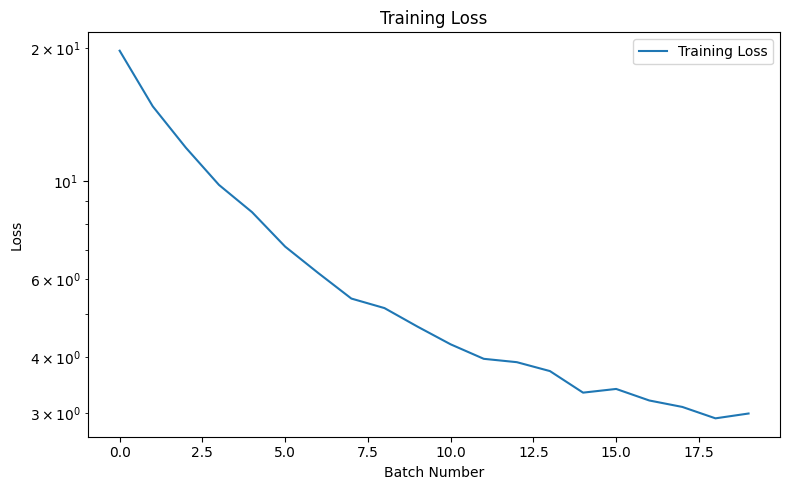

In [130]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    r_avg = (cumsum[N:] - cumsum[:-N]) / float(N)
    res = np.zeros(len(x))
    res[N-1:] = r_avg
    for i in range(N-1):
        res[i] = (cumsum[i+1]) / float(i+1)
    return res

plt.figure(figsize=(8, 5))
plt.plot(loss_array_epoch, label='Training Loss')
N_avg = 50  # Number of batches to average over
#plt.plot(running_mean(loss_array, N_avg), '-', label=f'Running mean ({N_avg} batches)')
plt.title('Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()

In [131]:
import datetime

dt = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
print(dt)

torch.save(model.state_dict(), f'results/model_jmena_rnn_{dt}.pth')

20250622230732


In [ ]:
model.load_state_dict(torch.load('results/model_jmena_rnn_20250621162737.pth'))

<All keys matched successfully>

## Vzorkování natrénováné RNN

In [190]:
znak = nameToTensor('O')[0].to(device)
jmeno = []
model.initHidden()
znak.shape

torch.Size([1, 62])

In [197]:
with torch.no_grad():
    znak = model(znak)
    print(znak.shape, znak)
    jmeno.append(tensorToName(znak.cpu()))
    znak = nameToTensor(jmeno[-1]).to(device)
print(jmeno)

torch.Size([1, 1, 62]) tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       device='cuda:0')
['O', 'A', 'A', 'A', 'A', 'A', 'A']


# Generování textu pomocí character-level RNN

## Příprava dat

In [ ]:
import os

url = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
path_to_file = 'datasets/shakespeare.txt'

if not os.path.exists(path_to_file):
    torch.hub.download_url_to_file(url, path_to_file)

100.0%


### Prozkoumání textu

In [8]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [9]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [43]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')
print(vocab)

65 unique characters
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Zpracování textu na tokeny

In [ ]:
allowed_characters = ''.join(vocab)
print(allowed_characters)
n_letters = len(vocab)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [ ]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def nameToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

## Zdroje

https://docs.pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

https://www.tensorflow.org/text/tutorials/text_generation